In [3]:
# ------------------------------------------------------------------------------ #
# @Author:        F. Paul Spitzner
# @Email:         paul.spitzner@ds.mpg.de
# @Created:       2023-10-09 16:49:35
# @Last Modified: 2023-10-09 16:49:42
# ------------------------------------------------------------------------------ #

%reload_ext autoreload
%autoreload 2
%reload_ext ipy_dict_hierarchy
%reload_ext watermark

import logging
logging.basicConfig(
    format="%(asctime)s | %(levelname)-8s | %(name)-s | %(funcName)-s | %(message)s",
    level=logging.WARNING,
)
log = logging.getLogger("notebook")
log.setLevel("DEBUG")

import re
import glob
import h5py
import sys
import os
import numpy as np
import xarray as xr
import pandas as pd
import dask

from tqdm import tqdm


# also needs to be added for each dask-worker
extra_path = os.path.abspath('../')
sys.path.append(extra_path)
log.info(f"project directory: {extra_path}")

from ana import utility as utl
from ana import plot_helper as ph

ph.log.setLevel("DEBUG")
utl.log.setLevel("DEBUG")

data_dir = "/data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code/experiment_analysis/data"

2024-04-16 11:39:14,390 | INFO     | notebook | <module> | project directory: /data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code/experiment_analysis


In [4]:
# load our results from timescale fitting
meta_df = pd.read_hdf(f"{data_dir}/all_units_merged_blocks.h5", key="meta_df")

# add metrics from image selectivity etc.
meta_df = utl.load_metrics(meta_df.reset_index(), data_dir)
meta_df

2024-04-16 11:39:29,815 | DEBUG    | its_utility | load_metrics | Loaded columns ['unit_id', 'g_dsi_dg', 'mod_idx_dg', 'image_selectivity_ns'] from /data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code/experiment_analysis/data/brain_observatory_unit_metrics_filtered.csv
2024-04-16 11:39:29,819 | DEBUG    | its_utility | load_metrics | Matched 6368 rows from meta_df in /data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code/experiment_analysis/data/brain_observatory_unit_metrics_filtered.csv


,index,session,stimulus,block,unit_id,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,...,R_tot,tau_R,tau_single,tau_double,tau_R_details,tau_single_details,tau_double_details,g_dsi_dg,image_selectivity_ns,mod_idx_dg
0,0,715093703,natural_movie_three,merged_3.0_and_6.0,950911932,VISam,SUCCESS,1078.491211,8.025100,/project.nst/neuroscience-raw/Allen/visual_cod...,...,0.074624,0.058510,0.000054,0.748946,"{'firing_rate': 8.012090922999178, 'firing_rat...","{'tau': 5.404084198337884e-05, 'mre': 6.575654...","{'tau': 0.7489462162647652, 'mre': 0.993346188...",0.095447,0.164169,1.353636
1,1,715093703,natural_movie_three,merged_3.0_and_6.0,950911986,VISam,SUCCESS,1079.203369,3.647135,/project.nst/neuroscience-raw/Allen/visual_cod...,...,0.112344,0.088701,2.302634,1.874703,"{'firing_rate': 3.6471291367256455, 'firing_ra...","{'tau': 2.3026338728859774, 'mre': 0.997830929...","{'tau': 1.874703126979266, 'mre': 0.9973364645...",0.108358,0.017271,0.639408
2,2,715093703,natural_movie_three,merged_3.0_and_6.0,950912164,VISam,SUCCESS,1077.872803,8.500075,/project.nst/neuroscience-raw/Allen/visual_cod...,...,0.065517,0.059416,1.026283,1.026284,"{'firing_rate': 8.475008697669026, 'firing_rat...","{'tau': 1.0262833654998276, 'mre': 0.995139899...","{'tau': 1.0262836602024297, 'mre': 0.995139901...",0.228699,0.598220,1.030492
3,3,715093703,natural_movie_three,merged_3.0_and_6.0,950912190,VISam,SUCCESS,1075.171875,4.399297,/project.nst/neuroscience-raw/Allen/visual_cod...,...,0.093197,0.116100,1.564297,1.363502,"{'firing_rate': 4.395563512916502, 'firing_rat...","{'tau': 1.5642971952849982, 'mre': 0.996808779...","{'tau': 1.363502294341311, 'mre': 0.9963396881...",0.056741,0.348424,0.999923
4,4,715093703,natural_movie_three,merged_3.0_and_6.0,950912214,VISam,SUCCESS,1073.492432,5.326540,/project.nst/neuroscience-raw/Allen/visual_cod...,...,0.118505,0.064748,0.605686,0.377801,"{'firing_rate': 5.317211538013684, 'firing_rat...","{'tau': 0.6056864214354767, 'mre': 0.991778883...","{'tau': 0.37780093267583975, 'mre': 0.98685270...",0.069080,0.422288,0.219870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11922,11922,847657808,natural_movie_one_more_repeats,merged_3.0_and_8.0,951190716,LP,SUCCESS,1669.521729,3.438110,/project.nst/neuroscience-raw/Allen/visual_cod...,...,0.082713,0.057480,0.154983,0.147879,"{'firing_rate': 3.3512526017879334, 'firing_ra...","{'tau': 0.15498293185242107, 'mre': 0.96825323...","{'tau': 0.1478788520828995, 'mre': 0.966753758...",NaN,NaN,NaN
11923,11923,847657808,natural_movie_one_more_repeats,merged_3.0_and_8.0,951190722,LP,SUCCESS,1677.163818,2.705758,/project.nst/neuroscience-raw/Allen/visual_cod...,...,0.061618,0.179228,0.287762,0.248368,"{'firing_rate': 2.6944277992922583, 'firing_ra...","{'tau': 0.2877620706377681, 'mre': 0.982774617...","{'tau': 0.24836808551088616, 'mre': 0.98006987...",NaN,NaN,NaN
11924,11924,847657808,natural_movie_one_more_repeats,merged_3.0_and_8.0,951190724,LP,SUCCESS,1676.766846,2.142814,/project.nst/neuroscience-raw/Allen/visual_cod...,...,0.075886,0.067158,0.345960,0.312267,"{'firing_rate': 2.132075359172695, 'firing_rat...","{'tau': 0.34596009410375744, 'mre': 0.98565140...","{'tau': 0.3122666989915499, 'mre': 0.984115555...",NaN,NaN,NaN
11925,11925,847657808,natural_movie_one_more_repeats,merged_3.0_and_8.0,951190819,LP,SUCCESS,1675.092041,1.989741,/project.nst/neuroscience-raw/Allen/visual_cod...,...,0.022345,0.432975,0.326839,0.326856,"{'firing_rate': 1.9873499711956635, 'firing_ra...","{'tau': 0.3268387313372349, 'mre': 0.984818356...","{'tau': 0.3268561287459293, 'mre': 0.984819158...",NaN,NaN,NaN


In [5]:
# TODO: make these default preprocessing steps.

# sanity check, selectivity should be present for all units in natural_movie_three
assert (
    len(meta_df.query("stimulus == 'natural_movie_three'"))
    == np.isfinite(meta_df.query("stimulus == 'natural_movie_three'")["mod_idx_dg"]).sum()
)

# exclude nans for now ~ 5 rows with low rates and one todo for unit 951021415
# TODO: 0.05 firing rate threshold seems better
meta_df = meta_df.query("R_tot == R_tot")

In [6]:
# we need a mapping from ephys acronyms to the names we use in the paper
structure_names = {
    "VISp" : "V1",
    "VISl" : "LM",
    "VISrl" : "RL",
    "VISal" : "AL",
    "VISpm" : "PM",
    "VISam" : "AM",
    "LGd" : "LGN",
    "LP" : "LP",
}

# apply to dataframe
meta_df["structure_name"] = meta_df["ecephys_structure_acronym"].apply(
    lambda x: structure_names[x]
)

# TODO: dump the final, cleaned dataframe to disk again.

meta_df

,index,session,stimulus,block,unit_id,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,...,tau_R,tau_single,tau_double,tau_R_details,tau_single_details,tau_double_details,g_dsi_dg,image_selectivity_ns,mod_idx_dg,structure_name
0,0,715093703,natural_movie_three,merged_3.0_and_6.0,950911932,VISam,SUCCESS,1078.491211,8.025100,/project.nst/neuroscience-raw/Allen/visual_cod...,...,0.058510,0.000054,0.748946,"{'firing_rate': 8.012090922999178, 'firing_rat...","{'tau': 5.404084198337884e-05, 'mre': 6.575654...","{'tau': 0.7489462162647652, 'mre': 0.993346188...",0.095447,0.164169,1.353636,AM
1,1,715093703,natural_movie_three,merged_3.0_and_6.0,950911986,VISam,SUCCESS,1079.203369,3.647135,/project.nst/neuroscience-raw/Allen/visual_cod...,...,0.088701,2.302634,1.874703,"{'firing_rate': 3.6471291367256455, 'firing_ra...","{'tau': 2.3026338728859774, 'mre': 0.997830929...","{'tau': 1.874703126979266, 'mre': 0.9973364645...",0.108358,0.017271,0.639408,AM
2,2,715093703,natural_movie_three,merged_3.0_and_6.0,950912164,VISam,SUCCESS,1077.872803,8.500075,/project.nst/neuroscience-raw/Allen/visual_cod...,...,0.059416,1.026283,1.026284,"{'firing_rate': 8.475008697669026, 'firing_rat...","{'tau': 1.0262833654998276, 'mre': 0.995139899...","{'tau': 1.0262836602024297, 'mre': 0.995139901...",0.228699,0.598220,1.030492,AM
3,3,715093703,natural_movie_three,merged_3.0_and_6.0,950912190,VISam,SUCCESS,1075.171875,4.399297,/project.nst/neuroscience-raw/Allen/visual_cod...,...,0.116100,1.564297,1.363502,"{'firing_rate': 4.395563512916502, 'firing_rat...","{'tau': 1.5642971952849982, 'mre': 0.996808779...","{'tau': 1.363502294341311, 'mre': 0.9963396881...",0.056741,0.348424,0.999923,AM
4,4,715093703,natural_movie_three,merged_3.0_and_6.0,950912214,VISam,SUCCESS,1073.492432,5.326540,/project.nst/neuroscience-raw/Allen/visual_cod...,...,0.064748,0.605686,0.377801,"{'firing_rate': 5.317211538013684, 'firing_rat...","{'tau': 0.6056864214354767, 'mre': 0.991778883...","{'tau': 0.37780093267583975, 'mre': 0.98685270...",0.069080,0.422288,0.219870,AM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11922,11922,847657808,natural_movie_one_more_repeats,merged_3.0_and_8.0,951190716,LP,SUCCESS,1669.521729,3.438110,/project.nst/neuroscience-raw/Allen/visual_cod...,...,0.057480,0.154983,0.147879,"{'firing_rate': 3.3512526017879334, 'firing_ra...","{'tau': 0.15498293185242107, 'mre': 0.96825323...","{'tau': 0.1478788520828995, 'mre': 0.966753758...",NaN,NaN,NaN,LP
11923,11923,847657808,natural_movie_one_more_repeats,merged_3.0_and_8.0,951190722,LP,SUCCESS,1677.163818,2.705758,/project.nst/neuroscience-raw/Allen/visual_cod...,...,0.179228,0.287762,0.248368,"{'firing_rate': 2.6944277992922583, 'firing_ra...","{'tau': 0.2877620706377681, 'mre': 0.982774617...","{'tau': 0.24836808551088616, 'mre': 0.98006987...",NaN,NaN,NaN,LP
11924,11924,847657808,natural_movie_one_more_repeats,merged_3.0_and_8.0,951190724,LP,SUCCESS,1676.766846,2.142814,/project.nst/neuroscience-raw/Allen/visual_cod...,...,0.067158,0.345960,0.312267,"{'firing_rate': 2.132075359172695, 'firing_rat...","{'tau': 0.34596009410375744, 'mre': 0.98565140...","{'tau': 0.3122666989915499, 'mre': 0.984115555...",NaN,NaN,NaN,LP
11925,11925,847657808,natural_movie_one_more_repeats,merged_3.0_and_8.0,951190819,LP,SUCCESS,1675.092041,1.989741,/project.nst/neuroscience-raw/Allen/visual_cod...,...,0.432975,0.326839,0.326856,"{'firing_rate': 1.9873499711956635, 'firing_ra...","{'tau': 0.3268387313372349, 'mre': 0.984818356...","{'tau': 0.3268561287459293, 'mre': 0.984819158...",NaN,NaN,NaN,LP


In [9]:
print(meta_df["block"].unique())
print(meta_df["stimulus"].unique())

['merged_3.0_and_6.0' 'merged_3.0_and_8.0']
['natural_movie_three' 'natural_movie_one_more_repeats']


2024-04-16 12:03:15,290 | INFO     | plot_helper | panel_areas_grouped | grouped tau_double for ['natural_movie_one_more_repeats'] ['merged_3.0_and_8.0'] with 5556 rows
2024-04-16 12:03:23,915 | INFO     | plot_helper | panel_areas_grouped | grouped tau_R for ['natural_movie_one_more_repeats'] ['merged_3.0_and_8.0'] with 5556 rows
2024-04-16 12:03:32,631 | INFO     | plot_helper | panel_areas_grouped | grouped R_tot for ['natural_movie_one_more_repeats'] ['merged_3.0_and_8.0'] with 5556 rows


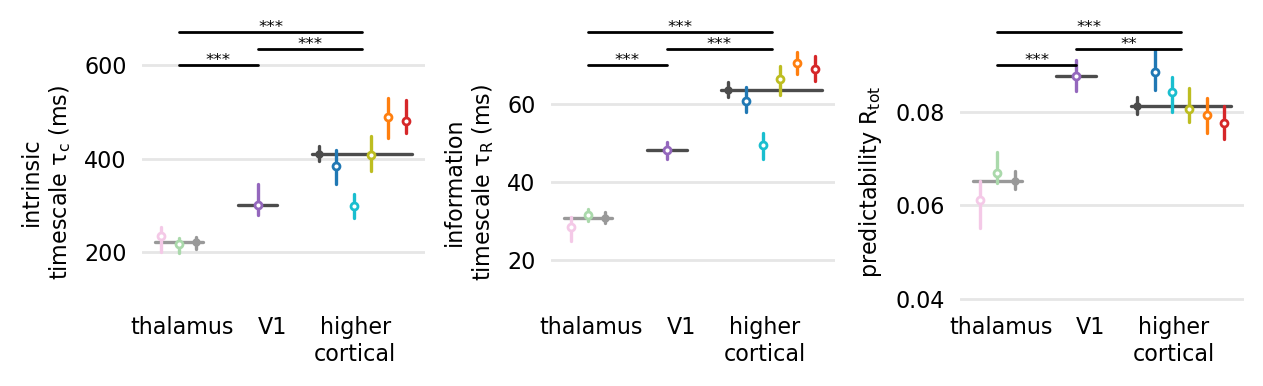

In [10]:
# Pick a block and plot the hierarchy.
# results should be consistent across blocks.

ph.log.setLevel("INFO")  # set to debug for p-values
df = meta_df.query("(stimulus == 'natural_movie_one_more_repeats') & (block == 'merged_3.0_and_8.0')")
ph.row_structure_groups(df);

2024-04-16 12:06:19,856 | INFO     | plot_helper | panel_hierarchy_score | dropping LGN and LP to focus on cortical hierarchy
2024-04-16 12:06:19,862 | INFO     | plot_helper | panel_hierarchy_score | plotting tau_double agains hierarchy score for ['natural_movie_one_more_repeats'] ['merged_3.0_and_8.0'] with 4765 rows
2024-04-16 12:06:24,280 | INFO     | plot_helper | panel_hierarchy_score | dropping LGN and LP to focus on cortical hierarchy
2024-04-16 12:06:24,284 | INFO     | plot_helper | panel_hierarchy_score | plotting tau_R agains hierarchy score for ['natural_movie_one_more_repeats'] ['merged_3.0_and_8.0'] with 4765 rows
2024-04-16 12:06:28,757 | INFO     | plot_helper | panel_hierarchy_score | dropping LGN and LP to focus on cortical hierarchy
2024-04-16 12:06:28,761 | INFO     | plot_helper | panel_hierarchy_score | plotting R_tot agains hierarchy score for ['natural_movie_one_more_repeats'] ['merged_3.0_and_8.0'] with 4765 rows


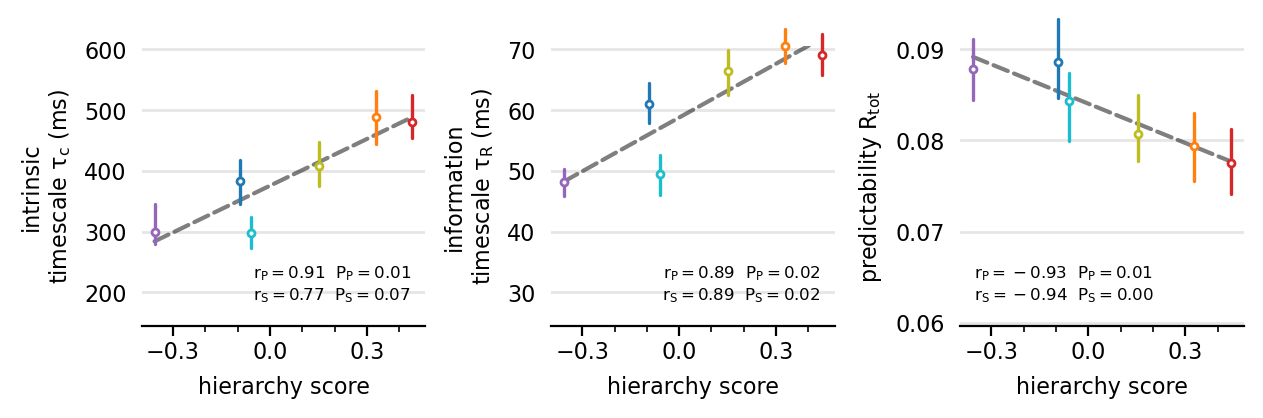

In [12]:
ph.log.setLevel("INFO")
df = meta_df.query("(stimulus == 'natural_movie_one_more_repeats') & (block == 'merged_3.0_and_8.0')")
ph.row_hierarchy_score(df);

In [15]:
%watermark -v --iversions --packages scipy

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

scipy: 1.11.1

numpy         : 1.24.4
prompt_toolkit: 3.0.39
re            : 2.2.1
IPython       : 8.14.0
pandas        : 2.0.3
sys           : 3.11.4 | packaged by conda-forge | (main, Jun 10 2023, 18:08:41) [Clang 15.0.7 ]
logging       : 0.5.1.2
h5py          : 3.9.0
sqlite3       : 2.6.0
matplotlib    : 3.7.2
xarray        : 2023.7.0
dask          : 2023.7.1

